# Libs, cuda, seed, params

In [3196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime 

In [3197]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3198]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
N_EPOCHS = 1000
IMG_SIZE = 32

# Data

In [3199]:
def convert_img_to_gray(image, path=None):
    imgGray = image.convert('L')
    if path:
        imgGray.save(path)
    return imgGray

In [3200]:
# 3-ch im -> 1-ch im
# im_in = Image.open('images/only_scaling/strange_small.jpg')
# im_out = Image.open('images/only_scaling/strange_big.jpg')
# im_in = convert_img_to_gray(im_in, 'images/only_scaling/strange_small_bw.jpg')
# im_out = convert_img_to_gray(im_out, 'images/only_scaling/strange_big_bw.jpg')

In [3201]:
transform = T.Compose(transforms=[
    T.ToPILImage(),
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    # torchvision.transforms.Normalize(mean=0.5, std=0.5)
])

In [3202]:
im_in = read_image('images/scal_rot/zero_big_left_bw.jpg')
im_in = transform(im_in)
im_out = read_image('images/scal_rot/zero_small_right_bw.jpg')
im_out = transform(im_out)

In [3203]:
print(im_in.shape)
print(im_out.shape)

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


+ In

<Figure size 432x288 with 0 Axes>

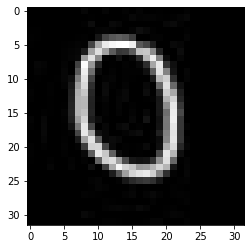

<Figure size 432x288 with 0 Axes>

In [3204]:
plt.imshow(im_in.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

+ Out

<Figure size 432x288 with 0 Axes>

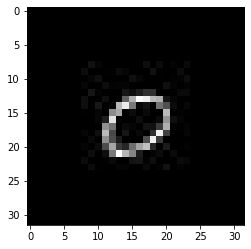

<Figure size 432x288 with 0 Axes>

In [3205]:
plt.imshow(im_out.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

In [3206]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [3207]:
train_loader = DataLoader(dataset=CustomTestDataset(im_in, im_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# Transform functions

In [3208]:
def get_rot_mat(theta, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[theta_cos, -theta_sin, zeros, theta_sin, theta_cos, zeros]).view(2,3)

In [3209]:
def get_scale_matrix(scale_factor, device):
    zeros = torch.zeros_like(input=scale_factor).to(device)
    return torch.stack(tensors=[scale_factor, zeros, zeros, zeros, scale_factor, zeros]).view(2,3)

In [3210]:
def get_scale_rot_matrix(theta, scale_factor, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), zeros, scale_factor * theta_sin, scale_factor*theta_cos, zeros]).view(2,3)

In [3211]:
def get_transform_matrix(theta, scale_factor, trans_x, trans_y, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), trans_x, scale_factor * theta_sin, scale_factor*theta_cos, trans_y]).view(2,3)

In [3212]:
def rot_img(x, theta, device):
    rot_mat = get_rot_mat(theta=theta, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=rot_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [3213]:
def scale_img(x, scale_factor, device):
    scale_mat = get_scale_matrix(scale_factor=scale_factor, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [3214]:
def scale_rot_img(x, theta, scale_factor, device):
    scale_mat = get_scale_rot_matrix(theta = theta, scale_factor=scale_factor, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [3215]:
def transform_img(x, theta, scale_factor, trans_x, trans_y, device):
    scale_mat = get_transform_matrix(theta = theta, scale_factor=scale_factor, trans_x=trans_x, trans_y=trans_y,device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

# Network

+ Functions

In [3216]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [3217]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [3218]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [3219]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=50):
    best_loss = 1e10
    train_losses = []
 
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')
    
    return model, optimizer, train_losses

+ Model

In [3220]:
class AttentionTransformation(nn.Module):

    def __init__(self, device, img_size):
        super().__init__()
        
        self.device = device
        self.img_size = img_size
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(2),
            nn.MaxPool2d(kernel_size=3)
        )

        self.angle_ff = nn.Sequential(
            nn.Linear(in_features=162, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=162, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1),
            # nn.ReLU()
        )
        
        self.trans_x_ff = nn.Sequential(
            nn.Linear(in_features=162, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1),
            # nn.ReLU()
        )
        
        self.trans_y_ff = nn.Sequential(
            nn.Linear(in_features=162, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1),
            # nn.ReLU()
        )


    def forward(self, x_inp, is_evaling=False):
        x = self.feature_extractor(x_inp)
        x = torch.flatten(x, 1)
        # print(x.shape)
        scale_factor = torch.exp(self.scale_ff(x))
        theta = self.angle_ff(x)
        trans_x = 2 * (self.trans_x_ff(x) / self.img_size)
        trans_y = 2 * (self.trans_y_ff(x) / self.img_size)
        if is_evaling:
            print("Params:\n-Scale: " + str(scale_factor)+ "\n-Theta: " + str(theta)+"\n-Trans_x: " + str(trans_x)+"\n-Trans_y: " + str(trans_y))
        trans_x =transform_img(x=x_inp, theta=theta, scale_factor=scale_factor, device=self.device, trans_x=trans_x, trans_y=trans_y)
        return trans_x

In [3221]:
torch.manual_seed(RANDOM_SEED)
model = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss(reduce="mean")

In [3222]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, N_EPOCHS, device, print_every=30)

03:12:57 --- Epoch: 29	Train loss: 0.0162
03:12:57 --- Epoch: 59	Train loss: 0.0131
03:12:57 --- Epoch: 89	Train loss: 0.0130
03:12:58 --- Epoch: 119	Train loss: 0.0130
03:12:58 --- Epoch: 149	Train loss: 0.0130
03:12:58 --- Epoch: 179	Train loss: 0.0130
03:12:58 --- Epoch: 209	Train loss: 0.0130
03:12:59 --- Epoch: 239	Train loss: 0.0130
03:12:59 --- Epoch: 269	Train loss: 0.0130
03:12:59 --- Epoch: 299	Train loss: 0.0130
03:12:59 --- Epoch: 329	Train loss: 0.0130
03:13:00 --- Epoch: 359	Train loss: 0.0130
03:13:00 --- Epoch: 389	Train loss: 0.0130
03:13:00 --- Epoch: 419	Train loss: 0.0130
03:13:01 --- Epoch: 449	Train loss: 0.0130
03:13:01 --- Epoch: 479	Train loss: 0.0130
03:13:01 --- Epoch: 509	Train loss: 0.0130
03:13:01 --- Epoch: 539	Train loss: 0.0130
03:13:02 --- Epoch: 569	Train loss: 0.0130
03:13:02 --- Epoch: 599	Train loss: 0.0130
03:13:02 --- Epoch: 629	Train loss: 0.0130
03:13:03 --- Epoch: 659	Train loss: 0.0130
03:13:03 --- Epoch: 689	Train loss: 0.0130
03:13:03 --- E

# Evaluation

In [3223]:
with torch.no_grad():
    y = model(next(iter(train_loader))[0].to(device),is_evaling=True)

Params:
-Scale: tensor([[1.9645]], device='cuda:0')
-Theta: tensor([[0.1358]], device='cuda:0')
-Trans_x: tensor([[-0.0295]], device='cuda:0')
-Trans_y: tensor([[-0.0262]], device='cuda:0')


In [3224]:
y.shape

torch.Size([1, 1, 32, 32])

+ What is as input:

<Figure size 432x288 with 0 Axes>

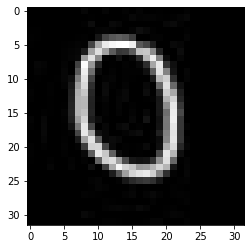

<Figure size 432x288 with 0 Axes>

In [3225]:
plt.imshow(im_in.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

+ What is doing model:

<Figure size 432x288 with 0 Axes>

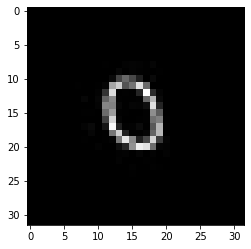

<Figure size 432x288 with 0 Axes>

In [3226]:
plt.imshow(y.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
plt.figure()

+ What should do model:

<Figure size 432x288 with 0 Axes>

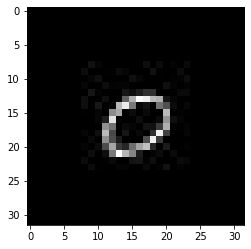

<Figure size 432x288 with 0 Axes>

In [3227]:
plt.imshow(im_out.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()